In [1]:
# pip install optuna

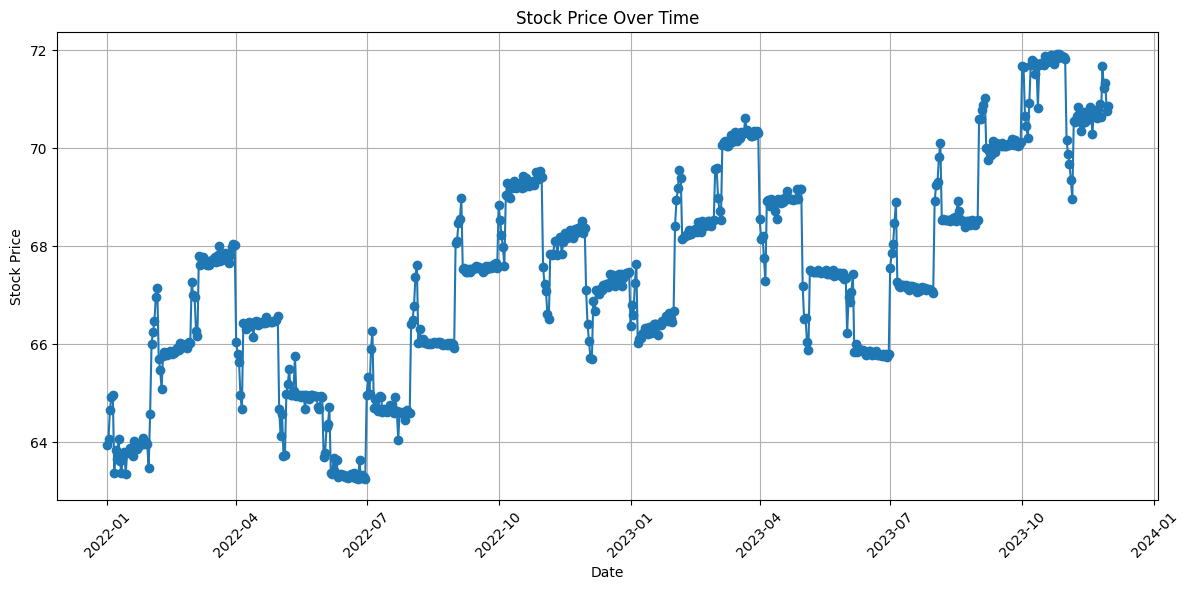

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
train_df = pd.read_csv('/kaggle/input/2024-datasciencetraining1-competition3/train.csv', parse_dates=['Date'])
df_test = pd.read_csv('/kaggle/input/2024-datasciencetraining1-competition3/submission.csv', parse_dates=['Date'])


# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Score'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.show()

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import seed_everything

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


df_train = pd.read_csv('/kaggle/input/2024-datasciencetraining1-competition3/train.csv', parse_dates=['Date'])
df_test = pd.read_csv('/kaggle/input/2024-datasciencetraining1-competition3/test.csv', parse_dates=['Date'])

def add_time_features(df):
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['ma7'] = df['Score'].rolling(window=7).mean()
    df['ma30'] = df['Score'].rolling(window=30).mean()
    df['diff'] = df['Score'].diff()
    df.fillna(0, inplace=True)
    return df

df_train = add_time_features(df_train)

target_col = 'Score'
feature_cols = ['Score', 'ma7', 'ma30', 'diff']

# Normalize the input data before creating the datasets
scaler = MinMaxScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

df_test['Score'] = 0
df_test = add_time_features(df_test)
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

class StockDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size, 1:]  # Features excluding the target
        y = self.data[idx+self.window_size, 0]  # Target
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(0)

window_size = 30  # 设置窗口大小
train_data = df_train[feature_cols].values
train_dataset = StockDataset(train_data, window_size)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)

class StockLSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'train_loss'}

input_size = len(feature_cols) - 1  # Input size is the number of features excluding the target
hidden_size = 50
num_layers = 3
output_size = 1
dropout_prob = 0.2
batch_size = 32
num_epochs = 150

checkpoint_callback = ModelCheckpoint(monitor='train_loss', save_top_k=1, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = StockLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
trainer = pl.Trainer(
    max_epochs=num_epochs,
    callbacks=[checkpoint_callback, lr_monitor],
    accelerator='gpu', 
    devices=1, 
    log_every_n_steps=10 
)
trainer.fit(model, train_loader)

model = model.to('cuda')

def predict(model, data, window_size):
    model.eval()
    predictions = [] 
    with torch.no_grad():
        for i in range(len(data) - window_size):
            x = torch.tensor(data[i:i+window_size, 1:], dtype=torch.float32).unsqueeze(0).cuda()
            y_pred = model(x)
            predictions.append(y_pred.item())
    return predictions

full_data = np.concatenate((train_data, df_test[feature_cols].values), axis=0)

start_date = df_train['Date'].max()
predictions = predict(model, full_data, window_size)
predictions = predictions[-len(df_test):]
predictions_df = pd.DataFrame({
    'Date': df_test['Date'],
    'Score': predictions
})

inverse_transformed = df_test[feature_cols].copy()
inverse_transformed['Score'] = predictions_df['Score']
inverse_transformed = scaler.inverse_transform(inverse_transformed)

predictions_df['Score'] = inverse_transformed[:, feature_cols.index('Score')]
predictions_df['Score'] = predictions_df['Score'] + 4
predictions_df.to_csv('submission.csv', index=False)
print(predictions_df)


2024-06-19 17:20:12.860765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 17:20:12.860861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 17:20:12.961715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: Runt

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 00037: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00043: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00057: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00063: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00069: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00079: reducing learning rate of group 0 to 1.5625e-05.
Epoch 00085: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00091: reducing learning rate of group 0 to 3.9063e-06.
Epoch 00097: reducing learning rate of group 0 to 1.9531e-06.
Epoch 00103: reducing learning rate of group 0 to 9.7656e-07.
Epoch 00109: reducing learning rate of group 0 to 4.8828e-07.
Epoch 00115: reducing learning rate of group 0 to 2.4414e-07.
Epoch 00121: reducing learning rate of group 0 to 1.2207e-07.
Epoch 00127: reducing learning rate of group 0 to 6.1035e-08.
Epoch 00133: reducing learning rate of group 0 to 3.0518e-08.
Epoch 00139: reducing learning rate of group 0 to 1.5259e-08.
        